### Azat Dovgeldiyev
### CSC 577
For this part you will experiment with parameter tuning for recommender systems implemented in Surprise. You will use the "review.csv" file from Yelp Core 5 distribution which includes ratings by users on various business establishments. The Yelp Core 5 data set is about 140k ratings, but it is fairly sparse (99.7%). Every user has rated at least five establishments and every establishment has at least five ratings. This data set is based on the Yelp challenge data set: https://www.kaggle.com/c/yelp-recsys-2013.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import cosine, correlation

### We won't use all of these, but they are imported for future extensions
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import SVD, SVDpp, NMF, SlopeOne, CoClustering
from surprise import Reader, similarities, Dataset, accuracy
from surprise.model_selection import cross_validate, KFold, ShuffleSplit
from surprise.model_selection import GridSearchCV

pd.options.display.float_format='{:,.3f}'.format

In [2]:
reviews = pd.read_csv("yelp-core5/review.csv", names=['userID', 'businessID', 'rating'])
print('Rows:', reviews.shape[0], '; Columns:', reviews.shape[1], '\n')

reviews.head()

Rows: 141454 ; Columns: 3 



,userID,businessID,rating
0,10000,0,5
1,10001,1,5
2,10002,2,5
3,10003,3,4
4,10004,4,5


In [3]:
print('No. of Unique Users    :', reviews.userID.nunique())
print('No. of Unique Business :', reviews.businessID.nunique())
print('No. of Unique Ratings  :', reviews.rating.nunique())

No. of Unique Users    : 8043
No. of Unique Business : 5199
No. of Unique Ratings  : 5


In [5]:
# Set Rating Scale
reader = Reader(rating_scale=(1, 5))

# Load data with rating scale
data = Dataset.load_from_df(reviews[['userID', 'businessID', 'rating']], reader)

In [6]:
knnbasic_cv = cross_validate(KNNBaseline(), data, cv=5, n_jobs=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=False)

In [7]:
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)

In [8]:
cocluster_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=False)
slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=5, verbose=False)

In [36]:
print('Algorithm\t RMSE')
print()
print('KNN Basic', '\t', knnbasic_cv['test_rmse'].mean())
print('KNN Means', '\t', knnmeans_cv['test_rmse'].mean())
print('KNN ZScore', '\t', knnz_cv['test_rmse'].mean())
print()
print('SVD', '\t\t', svd_cv['test_rmse'].mean())
print('SVDpp', '\t\t', svdpp_cv['test_rmse'].mean())
print('NMF', '\t\t', nmf_cv['test_rmse'].mean())
print()
print('SlopeOne', '\t', slope_cv['test_rmse'].mean())
print('CoClustering', '\t', cocluster_cv['test_rmse'].mean())
print()

Algorithm	 RMSE

KNN Basic 	 1.0594863316905083
KNN Means 	 1.0877090381395582
KNN ZScore 	 1.09376931697151

SVD 		 1.0237503598315298
SVDpp 		 1.021972213736008
NMF 		 1.1257179379599687

SlopeOne 	 1.1130160230691817
CoClustering 	 1.0851946670008341



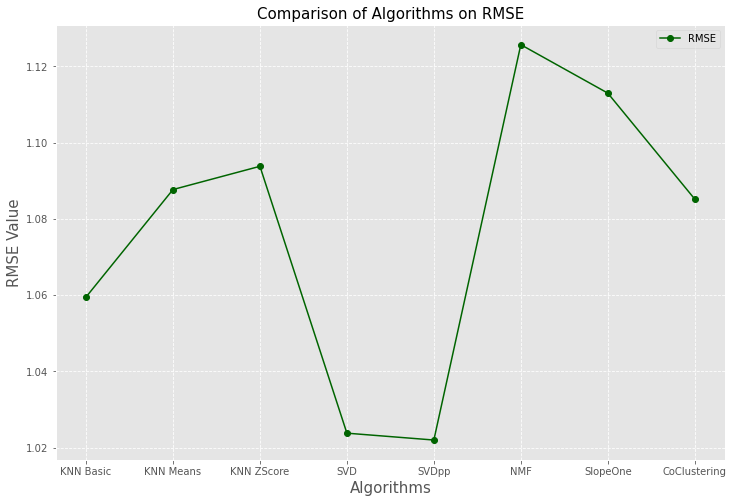

In [10]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, cocluster_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(12,8))

#plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')


plt.show()

In [11]:
from time import time
t0 = time()

svd_param_grid = {'n_epochs': [25, 30, 35], 
                  'lr_all': [0.001, 0.006, 0.007,0.008, 0.009, 0.01],
                  'reg_all': [0.01,0.05,0.08,0.09,0.1,0.4]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs.fit(data)

print("done in %0.3fs." % (time() - t0))

done in 25993.089s.


In [14]:
svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse'], cv=5, n_jobs=5)
svd_gs.fit(data)

print("done in %0.3fs." % (time() - t0))

done in 35981.583s.


In [18]:
print('SVDpp - RMSE:', svdpp_gs.best_score['rmse'])
print('SVD   - RMSE:', svd_gs.best_score['rmse'])

SVDpp - RMSE: 1.014211067642224
SVD   - RMSE: 1.014742426188841


In [16]:
print('RMSE =', svdpp_gs.best_params['rmse'])

RMSE = {'n_epochs': 25, 'lr_all': 0.006, 'reg_all': 0.1}


In [17]:
print('RMSE =', svd_gs.best_params['rmse'])

RMSE = {'n_epochs': 35, 'lr_all': 0.006, 'reg_all': 0.4}


In [43]:
svdppRMSE = []
kf = KFold(n_splits=5, random_state=44)
for trainset, testset in kf.split(data):
    svd_pp_eval = SVDpp(n_epochs= 25, lr_all= 0.006, reg_all= 0.1)
    svd_pp_eval.fit(trainset)
    predictions = svd_pp_eval.test(testset)
    svdppRMSE.append(accuracy.rmse(predictions, verbose=True))
svdppRMSE = np.array(svdppRMSE)

RMSE: 1.0124
RMSE: 1.0160
RMSE: 1.0147
RMSE: 1.0121
RMSE: 1.0154


In [40]:
svdppRMSE = np.array(svdppRMSE)

In [41]:
svdRMSE = []
kf = KFold(n_splits=5, random_state=44)
for trainset, testset in kf.split(data):
    svd = SVD(n_epochs= 35, lr_all= 0.006, reg_all= 0.4)
    svd.fit(trainset)
    predictions = svd.test(testset)
    svdRMSE.append(accuracy.rmse(predictions, verbose=True))
svdRMSE = np.array(svdRMSE)

RMSE: 1.0147
RMSE: 1.0177
RMSE: 1.0165
RMSE: 1.0144
RMSE: 1.0167


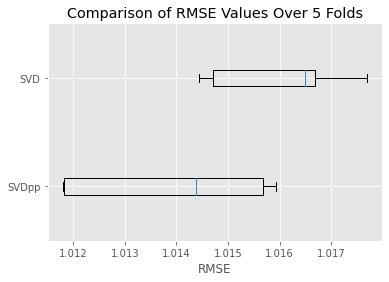

In [42]:
plt.boxplot([svdppRMSE, svdRMSE], labels= ['SVDpp', 'SVD'], vert=False, whis=50)
plt.xlabel('RMSE')
plt.title('Comparison of RMSE Values Over 5 Folds')
plt.show()